---

# **Credit Card Customer Clustering & Welcome Offer Suggestion**

---


## **Import Library**

In [79]:
#Basic python library which need to import
import pandas as pd
import numpy as np

#Library for Nice graphing
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from collections import Counter

import sys

# Settings
pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=3)
sns.set(style="darkgrid")
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import warnings
warnings.filterwarnings('ignore')

# **A. Credit Card Customer Clustering**

## **1. Data Visualization**

### **1.1 Getting Dataset**

In [2]:
# Getting the Credit Card Transaction Dataset downloaded from GitHub
!wget -O credit_card_transactions-ibm_v3.zip 'https://raw.githubusercontent.com/tandonvivek/bits-project/v1-dev/credit_card_transactions-ibm_v3.zip'

# Unzipping the CC Transaction Dataset to get the CSV file
!unzip -o   credit_card_transactions-ibm_v3.zip

--2021-08-31 09:17:50--  https://raw.githubusercontent.com/tandonvivek/bits-project/v1-dev/credit_card_transactions-ibm_v3.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35801842 (34M) [application/zip]
Saving to: ‘credit_card_transactions-ibm_v3.zip’

credit_card_transac 100%[===================>]  34.14M   147MB/s    in 0.2s    

2021-08-31 09:17:50 (147 MB/s) - ‘credit_card_transactions-ibm_v3.zip’ saved [35801842/35801842]

Archive:  credit_card_transactions-ibm_v3.zip
  inflating: credit_card_transactions-ibm_v3.csv  


### **1.2 Load CC Transaction Dataset and do initial raw data analysis**

In [3]:
# Load dataset and check data sample
cc_trans = pd.read_csv("credit_card_transactions-ibm_v3.csv")
cc_trans.head(100)

,Customer Id,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,MCC
0,1000020180,2020,1,2,06:28,4583.25,Chip Transaction,5817218446178736267,5912
1,1000020180,2020,1,5,06:02,4526.90,Chip Transaction,-727612092139916043,5411
2,1000020180,2020,1,5,17:56,298.90,Online Transaction,6455213054093379528,5815
3,1000020180,2020,1,6,06:23,4049.85,Chip Transaction,4722913068560264812,5411
4,1000020180,2020,1,11,06:02,3762.50,Chip Transaction,2027553650310142703,5541
...,...,...,...,...,...,...,...,...,...
95,1000020180,2020,6,6,10:46,72.45,Chip Transaction,-7232193519160172381,7542
96,1000020180,2020,6,7,12:48,350.70,Swipe Transaction,5205099864768539121,5812
97,1000020180,2020,6,8,06:43,924.35,Chip Transaction,7908279193798077442,5912
98,1000020180,2020,6,15,17:28,3812.55,Chip Transaction,6130287678940178238,5651


In [4]:
# Check the dataset shape
cc_trans.shape

(3782053, 9)

In [5]:
# Check dataset type
cc_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3782053 entries, 0 to 3782052
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   Customer Id    int64  
 1   Year           int64  
 2   Month          int64  
 3   Day            int64  
 4   Time           object 
 5   Amount         float64
 6   Use Chip       object 
 7   Merchant Name  int64  
 8   MCC            int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 259.7+ MB


In [6]:
# Find the total number of missing values in the dataframe
print ("\nMissing values :  ", cc_trans.isnull().sum().values.sum())

# printing total numbers of Unique value in the dataframe. 
print ("\nUnique values :  \n", cc_trans.nunique())


Missing values :   0

Unique values :  
 Customer Id      13058
Year                 1
Month               12
Day                 31
Time              1440
Amount           51026
Use Chip             3
Merchant Name    48798
MCC                109
dtype: int64


## **2. Data Pre-Processing**

### **2.1 Data Reduction**

In [7]:
# Drop columns not required for customer segmentation based on transaction categories
cc_trans = cc_trans.drop(['Year', 'Month', 'Day', 'Time', 'Use Chip', 'Merchant Name'], axis = 1)
cc_trans.head()

,Customer Id,Amount,MCC
0,1000020180,4583.25,5912
1,1000020180,4526.90,5411
2,1000020180,298.90,5815
3,1000020180,4049.85,5411
4,1000020180,3762.50,5541


### **2.2 Data Transformation**

In [8]:
# Grouping and Convering Merchant Category Code to Merchant Category

cc_trans['MCC'] = np.where(cc_trans['MCC'].astype(str).astype(int).between(1, 1499), 10001, cc_trans['MCC'])
cc_trans['MCC'] = np.where(cc_trans['MCC'].astype(str).astype(int).between(1500, 2999), 10002, cc_trans['MCC'])
cc_trans['MCC'] = np.where(cc_trans['MCC'].astype(str).astype(int).between(3000, 3299), 10003, cc_trans['MCC'])
cc_trans['MCC'] = np.where(cc_trans['MCC'].astype(str).astype(int).between(3300, 3499), 10004, cc_trans['MCC'])
cc_trans['MCC'] = np.where(cc_trans['MCC'].astype(str).astype(int).between(3500, 3999), 10005, cc_trans['MCC'])
cc_trans['MCC'] = np.where(cc_trans['MCC'].astype(str).astype(int).between(4000, 4799), 10006, cc_trans['MCC'])
cc_trans['MCC'] = np.where(cc_trans['MCC'].astype(str).astype(int).between(4800, 4999), 10007, cc_trans['MCC'])
cc_trans['MCC'] = np.where(cc_trans['MCC'].astype(str).astype(int).between(5000, 5599), 10008, cc_trans['MCC'])
cc_trans['MCC'] = np.where(cc_trans['MCC'].astype(str).astype(int).between(5600, 5699), 10009, cc_trans['MCC'])
cc_trans['MCC'] = np.where(cc_trans['MCC'].astype(str).astype(int).between(5700, 7299), 10010, cc_trans['MCC'])
cc_trans['MCC'] = np.where(cc_trans['MCC'].astype(str).astype(int).between(7300, 7999), 10011, cc_trans['MCC'])
cc_trans['MCC'] = np.where(cc_trans['MCC'].astype(str).astype(int).between(8000, 8999), 10012, cc_trans['MCC'])
cc_trans['MCC'] = np.where(cc_trans['MCC'].astype(str).astype(int).between(9000, 9999), 10013, cc_trans['MCC'])
di = {10001: "Agricultural Services", 10002: "Contracted Services", 10003: "Airlines", 10004: "Car Rental", 10005: "Lodging", 10006: "Transportation Services", 10007: "Utility Services", 10008: "Retail Outlet Services", 10009: "Clothing Stores", 10010: "Miscellaneous Stores", 10011: "Business Services", 10012: "Professional Services and Membership", 10013: "Government Services"}
cc_trans['MCC'] = cc_trans['MCC'].map(di)
cc_trans.head(100)

,Customer Id,Amount,MCC
0,1000020180,4583.25,Miscellaneous Stores
1,1000020180,4526.90,Retail Outlet Services
2,1000020180,298.90,Miscellaneous Stores
3,1000020180,4049.85,Retail Outlet Services
4,1000020180,3762.50,Retail Outlet Services
...,...,...,...
95,1000020180,72.45,Business Services
96,1000020180,350.70,Miscellaneous Stores
97,1000020180,924.35,Miscellaneous Stores
98,1000020180,3812.55,Clothing Stores


In [9]:
# Groupby 'Customer Id' and 'MCC' to get the total spending on each category by a customer
cc_trans = cc_trans.groupby(['Customer Id', 'MCC']).agg({'Amount':sum})
cc_trans.head(100)

Amount
Customer Id MCC                                            
1000020180  Business Services                      19087.25
            Clothing Stores                         3812.55
            Lodging                                27393.80
            Miscellaneous Stores                  115864.00
            Retail Outlet Services                335237.00
...                                                     ...
1000120182  Government Services                     2620.80
            Lodging                               114020.90
            Miscellaneous Stores                  180180.35
            Professional Services and Membership   42939.05
            Retail Outlet Services                119225.40

[100 rows x 1 columns]

In [10]:
# Rest index to get back default indexing
cc_trans = cc_trans.reset_index()
cc_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94738 entries, 0 to 94737
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Customer Id  94738 non-null  int64  
 1   MCC          94738 non-null  object 
 2   Amount       94738 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.2+ MB


In [11]:
cc_trans.head(100)

,Customer Id,MCC,Amount
0,1000020180,Business Services,19087.25
1,1000020180,Clothing Stores,3812.55
2,1000020180,Lodging,27393.80
3,1000020180,Miscellaneous Stores,115864.00
4,1000020180,Retail Outlet Services,335237.00
...,...,...,...
95,1000120182,Government Services,2620.80
96,1000120182,Lodging,114020.90
97,1000120182,Miscellaneous Stores,180180.35
98,1000120182,Professional Services and Membership,42939.05


In [12]:
# Checking total number of customers in the dataframe
len(cc_trans['Customer Id'].unique())

13058

In [13]:
# Checking total number of unique merchant categories in the dataframe
len(cc_trans.MCC.unique())

12

In [14]:
# Checking unique merchant categories in the dataframe
cc_trans.MCC.unique()

array(['Business Services', 'Clothing Stores', 'Lodging',
       'Miscellaneous Stores', 'Retail Outlet Services',
       'Transportation Services', 'Utility Services', 'Airlines',
       'Car Rental', 'Contracted Services',
       'Professional Services and Membership', 'Government Services'],
      dtype=object)

In [15]:
# Converting dataframe to have a row for each customer with total spending on each merchant category
cc_trans = pd.pivot_table(cc_trans, index = 'Customer Id', columns = 'MCC', values = 'Amount').reset_index().rename_axis(None,axis=1)
cc_trans.head()

,Customer Id,Airlines,Business Services,Car Rental,Clothing Stores,Contracted Services,Government Services,Lodging,Miscellaneous Stores,Professional Services and Membership,Retail Outlet Services,Transportation Services,Utility Services
0,1000020180,NaN,19087.25,NaN,3812.55,NaN,NaN,27393.80,115864.00,NaN,335237.00,28567.0,67618.6
1,1000020181,NaN,39659.20,NaN,NaN,NaN,NaN,NaN,110605.25,NaN,305949.35,NaN,62769.7
2,1000020182,NaN,18628.40,NaN,2353.75,NaN,NaN,NaN,133589.40,NaN,228393.20,NaN,49882.7
3,1000020183,34771.1,79723.70,53590.6,7250.60,5707.1,NaN,52540.25,417228.70,NaN,969084.55,37072.7,238146.3
4,1000020190,NaN,28054.25,NaN,2457.70,NaN,NaN,18439.75,149428.65,NaN,284249.35,2207.8,32875.5


In [16]:
cc_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13058 entries, 0 to 13057
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Customer Id                           13058 non-null  int64  
 1   Airlines                              3747 non-null   float64
 2   Business Services                     12285 non-null  float64
 3   Car Rental                            3881 non-null   float64
 4   Clothing Stores                       8076 non-null   float64
 5   Contracted Services                   825 non-null    float64
 6   Government Services                   4217 non-null   float64
 7   Lodging                               6252 non-null   float64
 8   Miscellaneous Stores                  12924 non-null  float64
 9   Professional Services and Membership  8152 non-null   float64
 10  Retail Outlet Services                12970 non-null  float64
 11  Transportation 

### **2.3 Data Cleaning**

In [17]:
# Find the total number of missing values in the dataframe
print ("\nMissing values :  ", cc_trans.isnull().sum().values.sum())

# Printing total numbers of Unique value in the dataframe. 
print ("\nUnique values :  \n", cc_trans.nunique())


Missing values :   61958

Unique values :  
 Customer Id                             13058
Airlines                                 3719
Business Services                       11914
Car Rental                               3824
Clothing Stores                          7257
Contracted Services                       815
Government Services                      3511
Lodging                                  6171
Miscellaneous Stores                    12837
Professional Services and Membership     7921
Retail Outlet Services                  12929
Transportation Services                  8821
Utility Services                        11643
dtype: int64


In [18]:
cc_trans.head()

,Customer Id,Airlines,Business Services,Car Rental,Clothing Stores,Contracted Services,Government Services,Lodging,Miscellaneous Stores,Professional Services and Membership,Retail Outlet Services,Transportation Services,Utility Services
0,1000020180,NaN,19087.25,NaN,3812.55,NaN,NaN,27393.80,115864.00,NaN,335237.00,28567.0,67618.6
1,1000020181,NaN,39659.20,NaN,NaN,NaN,NaN,NaN,110605.25,NaN,305949.35,NaN,62769.7
2,1000020182,NaN,18628.40,NaN,2353.75,NaN,NaN,NaN,133589.40,NaN,228393.20,NaN,49882.7
3,1000020183,34771.1,79723.70,53590.6,7250.60,5707.1,NaN,52540.25,417228.70,NaN,969084.55,37072.7,238146.3
4,1000020190,NaN,28054.25,NaN,2457.70,NaN,NaN,18439.75,149428.65,NaN,284249.35,2207.8,32875.5


In [19]:
# Replace all missing values with zero as NaN in dataframe basically means no transaction by customer in that category
cc_trans.fillna(value=0, inplace=True)
cc_trans.isnull().any()

Customer Id                             False
Airlines                                False
Business Services                       False
Car Rental                              False
Clothing Stores                         False
Contracted Services                     False
Government Services                     False
Lodging                                 False
Miscellaneous Stores                    False
Professional Services and Membership    False
Retail Outlet Services                  False
Transportation Services                 False
Utility Services                        False
dtype: bool

In [20]:
cc_trans.head()

,Customer Id,Airlines,Business Services,Car Rental,Clothing Stores,Contracted Services,Government Services,Lodging,Miscellaneous Stores,Professional Services and Membership,Retail Outlet Services,Transportation Services,Utility Services
0,1000020180,0.0,19087.25,0.0,3812.55,0.0,0.0,27393.80,115864.00,0.0,335237.00,28567.0,67618.6
1,1000020181,0.0,39659.20,0.0,0.00,0.0,0.0,0.00,110605.25,0.0,305949.35,0.0,62769.7
2,1000020182,0.0,18628.40,0.0,2353.75,0.0,0.0,0.00,133589.40,0.0,228393.20,0.0,49882.7
3,1000020183,34771.1,79723.70,53590.6,7250.60,5707.1,0.0,52540.25,417228.70,0.0,969084.55,37072.7,238146.3
4,1000020190,0.0,28054.25,0.0,2457.70,0.0,0.0,18439.75,149428.65,0.0,284249.35,2207.8,32875.5


## **3. Feature Engineering**

### **3.1 Analyzing Dataset Features**

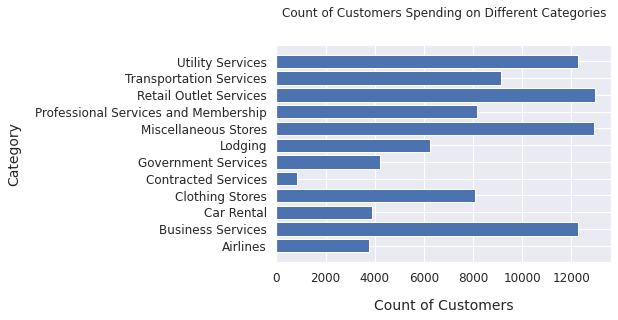

In [21]:
# Plot the graph see customer counts spending on each category
x = cc_trans.columns.tolist()
x.remove('Customer Id')
y = []

for col in x:
   val=(cc_trans[cc_trans[col] > 0]).count()
   y.append(val[1])

plt.barh(x, y)
plt.ylabel("Category", labelpad=14)
plt.xlabel("Count of Customers", labelpad=14)
plt.title("Count of Customers Spending on Different Categories", y=1.1);
plt.show()

In [22]:
# Drop the column 'Miscellaneous Stores' as it will not have any positive addition to customer's spending habit
cc_trans_dummy = cc_trans.drop(['Miscellaneous Stores'], axis = 1)

In [23]:
# Creating 'cols' with all categories
cols = cc_trans_dummy.columns.tolist()
cols.remove('Customer Id')

# Doing dataframe describe
cc_trans_dummy_temp = cc_trans_dummy[cols]
cc_trans_dummy_temp.describe()

,Airlines,Business Services,Car Rental,Clothing Stores,Contracted Services,Government Services,Lodging,Professional Services and Membership,Retail Outlet Services,Transportation Services,Utility Services
count,13058.000000,1.305800e+04,13058.000000,13058.000000,13058.000000,13058.000000,13058.000000,13058.000000,1.305800e+04,1.305800e+04,1.305800e+04
mean,12978.801987,3.729526e+04,11303.288007,5506.478274,373.292771,1074.472098,29258.416155,18220.156253,1.935263e+05,4.672183e+04,8.531726e+04
std,30387.406833,9.760884e+04,22744.904023,20004.767889,1725.788409,4193.389130,49293.721353,38913.236666,3.371079e+05,1.352676e+05,1.612758e+05
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000,4.401250e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.421565e+04,0.000000e+00,1.135426e+04
50%,0.000000,1.424465e+04,0.000000,1386.700000,0.000000,0.000000,0.000000,5194.875000,9.969330e+04,4.023425e+03,3.781470e+04
75%,13887.212500,3.776518e+04,15577.012500,5309.937500,0.000000,510.562500,39310.862500,19760.212500,2.274730e+05,3.403365e+04,1.004133e+05
max,442174.950000,3.388216e+06,247156.000000,755331.850000,33526.850000,78184.050000,495216.050000,867209.000000,9.405753e+06,2.612134e+06,3.183689e+06


### **3.2 Enhancing Features**

In [24]:
# Dividing all category spend by total customer's spend to get categories percentage spend
cc_trans_dummy.loc[:,"Airlines":"Utility Services"] = cc_trans_dummy.loc[:,"Airlines":"Utility Services"].div(cc_trans_dummy_temp.sum(axis = 1), axis=0)

cc_trans_dummy_temp = cc_trans_dummy[cols]
cc_trans_dummy_temp.describe()

,Airlines,Business Services,Car Rental,Clothing Stores,Contracted Services,Government Services,Lodging,Professional Services and Membership,Retail Outlet Services,Transportation Services,Utility Services
count,13054.000000,13054.000000,13054.000000,13054.000000,13054.000000,13054.000000,13054.000000,13054.000000,13054.000000,13054.000000,13054.000000
mean,0.024666,0.091188,0.022861,0.013522,0.000800,0.003897,0.058198,0.041996,0.460861,0.087550,0.194460
std,0.075285,0.101938,0.055728,0.028724,0.005593,0.016114,0.094167,0.070101,0.216626,0.152731,0.152754
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029104,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.293065,0.000000,0.087261
50%,0.000000,0.061899,0.000000,0.003530,0.000000,0.000000,0.000000,0.015246,0.441095,0.020022,0.162731
75%,0.018205,0.113272,0.021500,0.015403,0.000000,0.001168,0.091270,0.054802,0.616000,0.094009,0.263834
max,1.000000,1.000000,1.000000,0.492596,0.156755,0.611111,1.000000,0.675249,1.000000,1.000000,1.000000


In [25]:
cc_trans_dummy.head(100)

,Customer Id,Airlines,Business Services,Car Rental,Clothing Stores,Contracted Services,Government Services,Lodging,Professional Services and Membership,Retail Outlet Services,Transportation Services,Utility Services
0,1000020180,0.000000,0.039623,0.000000,0.007915,0.000000,0.00000,0.056867,0.000000,0.695922,0.059303,0.140370
1,1000020181,0.000000,0.097114,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.749181,0.000000,0.153705
2,1000020182,0.000000,0.062249,0.000000,0.007865,0.000000,0.00000,0.000000,0.000000,0.763198,0.000000,0.166688
3,1000020183,0.023528,0.053944,0.036262,0.004906,0.003862,0.00000,0.035551,0.000000,0.655723,0.025085,0.161140
4,1000020190,0.000000,0.076176,0.000000,0.006673,0.000000,0.00000,0.050069,0.000000,0.771820,0.005995,0.089267
...,...,...,...,...,...,...,...,...,...,...,...,...
95,1001420190,0.008454,0.016698,0.049755,0.004929,0.000000,0.00023,0.017895,0.037672,0.250029,0.005159,0.609180
96,1001420200,0.000000,0.014548,0.000000,0.018376,0.000000,0.00000,0.000000,0.015393,0.304707,0.000000,0.646977
97,1001520180,0.000000,0.099526,0.071862,0.000000,0.000000,0.00000,0.127905,0.005226,0.641822,0.000000,0.053659
98,1001520182,0.039349,0.096189,0.000000,0.000000,0.000000,0.00000,0.000000,0.047125,0.423134,0.000000,0.394203


In [26]:
cc_trans_dummy.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13058 entries, 0 to 13057
Data columns (total 12 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Customer Id                           13058 non-null  int64  
 1   Airlines                              13054 non-null  float64
 2   Business Services                     13054 non-null  float64
 3   Car Rental                            13054 non-null  float64
 4   Clothing Stores                       13054 non-null  float64
 5   Contracted Services                   13054 non-null  float64
 6   Government Services                   13054 non-null  float64
 7   Lodging                               13054 non-null  float64
 8   Professional Services and Membership  13054 non-null  float64
 9   Retail Outlet Services                13054 non-null  float64
 10  Transportation Services               13054 non-null  float64
 11  Utility Service

In [27]:
cc_trans_dummy.shape


(13058, 12)

In [28]:
# Find the total number of missing values in the dataframe
print ("\nMissing values :  ", cc_trans_dummy.isnull().sum().values.sum())


Missing values :   44


In [29]:
# Replace all missing values with zero
cc_trans_dummy.fillna(value=0, inplace=True)

In [30]:
# Now again check the missing values.

cc_trans_dummy.isnull().any()

Customer Id                             False
Airlines                                False
Business Services                       False
Car Rental                              False
Clothing Stores                         False
Contracted Services                     False
Government Services                     False
Lodging                                 False
Professional Services and Membership    False
Retail Outlet Services                  False
Transportation Services                 False
Utility Services                        False
dtype: bool

### **3.3 Extreme value Treatment**

In [31]:
# Since there are variables having extreme values so doing log-transformation on the dataset to remove outlier effect
cc_trans_dummy=cc_trans_dummy.drop(['Customer Id'],axis=1).applymap(lambda x: np.log(x+1))
cc_trans_dummy.head()

,Airlines,Business Services,Car Rental,Clothing Stores,Contracted Services,Government Services,Lodging,Professional Services and Membership,Retail Outlet Services,Transportation Services,Utility Services
0,0.000000,0.038859,0.00000,0.007883,0.000000,0.0,0.055309,0.0,0.528227,0.057611,0.131353
1,0.000000,0.092683,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.559148,0.000000,0.142978
2,0.000000,0.060388,0.00000,0.007835,0.000000,0.0,0.000000,0.0,0.567129,0.000000,0.154169
3,0.023255,0.052540,0.03562,0.004894,0.003854,0.0,0.034934,0.0,0.504238,0.024775,0.149402
4,0.000000,0.073414,0.00000,0.006651,0.000000,0.0,0.048856,0.0,0.572007,0.005977,0.085505


### **3.4 Heat Map**

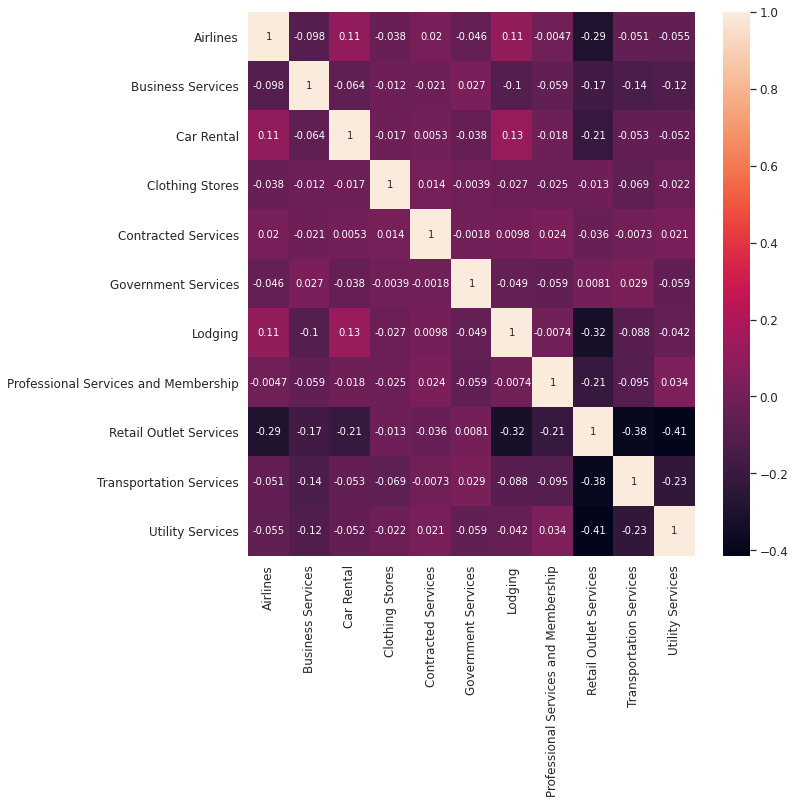

In [32]:
# Plotting HeatMap for all categories
plt.figure(figsize=(10,10))
sns.heatmap(cc_trans_dummy.corr(), annot=True)
plt.show()

### **3.5 Applying PCA**

**With the help of Principal Component Analysis we will reduce features**

In [33]:
# We have 11 features so our n_component will be 11.
pc = PCA(n_components = 11)
cc_trans_pca = pc.fit(cc_trans_dummy)

# Lets check if we will take 11 component then how much varience it explain. Ideally it should be 1 i.e 100%
sum(cc_trans_pca.explained_variance_ratio_)

1.0000000000000002

In [34]:
# Checking varience for the complete range of features
var_ratio = {}
for n in range(2,12):
    pc = PCA(n_components = n)
    cc_trans_pca = pc.fit(cc_trans_dummy)
    var_ratio[n] = sum(cc_trans_pca.explained_variance_ratio_)

var_ratio

{2: 0.6196255304613698,
 3: 0.7469482517728394,
 4: 0.8477445021851773,
 5: 0.9048274808785393,
 6: 0.9528235203835839,
 7: 0.9840907507887438,
 8: 0.994313964323912,
 9: 0.9977282826413585,
 10: 0.9996213181026302,
 11: 1.0000000000000002}

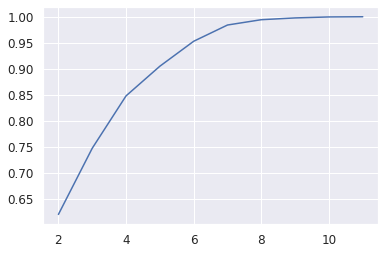

In [35]:
pd.Series(var_ratio).plot()

**Since 6 components are explaining about 95% variance so we select 6 components**

In [36]:
# Original dataframe shape
cc_trans_dummy.shape

(13058, 11)

In [37]:
pc = PCA(n_components = 6)
cc_trans_pca = pc.fit(cc_trans_dummy)
cc_trans_reduced = cc_trans_pca.fit_transform(cc_trans_dummy)
df_reduced = pd.DataFrame(cc_trans_reduced)

In [38]:
# Reduced dataframe shape
df_reduced.shape

(13058, 6)

In [39]:
df_reduced.head()

,0,1,2,3,4,5
0,-0.163734,0.014217,-0.044914,-0.034781,-0.039915,0.003926
1,-0.210057,-0.035973,-0.030572,0.035495,-0.021498,0.016939
2,-0.214104,-0.042863,-0.054910,0.012256,-0.017606,0.017641
3,-0.146036,-0.021835,-0.028058,-0.020559,-0.014653,0.032577
4,-0.233971,0.005579,0.004020,-0.014148,-0.033526,0.005902


**So initially we had 11 variables now its 6 so our variable go reduced**

In [40]:
col_list=cc_trans_dummy.columns

In [41]:
col_list

Index(['Airlines', 'Business Services', 'Car Rental', 'Clothing Stores',
       'Contracted Services', 'Government Services', 'Lodging',
       'Professional Services and Membership', 'Retail Outlet Services',
       'Transportation Services', 'Utility Services'],
      dtype='object')

In [42]:
pd.DataFrame(cc_trans_pca.components_.T, columns=['PC_' +str(i) for i in range(6)],index=col_list)

,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5
Airlines,0.079147,-0.000371,0.167341,-0.182653,0.420550,0.695801
Business Services,0.035786,-0.020224,0.516671,0.747010,-0.214257,-0.028219
Car Rental,0.044049,-0.001865,0.110945,-0.111635,0.102851,0.166559
Clothing Stores,-0.002551,-0.006654,0.009900,0.001196,0.008877,0.002917
Contracted Services,0.001018,-0.000697,0.000134,-0.001326,0.002327,-0.000066
Government Services,-0.001745,0.006339,0.000504,0.009226,-0.006021,0.003203
Lodging,0.131071,-0.029100,0.430570,-0.615422,-0.498139,-0.224902
Professional Services and Membership,0.058812,-0.047437,0.080356,-0.048262,0.667381,-0.658229
Retail Outlet Services,-0.859488,-0.005414,-0.255124,-0.021260,-0.128072,-0.027767
Transportation Services,0.322631,0.743927,-0.420555,0.076178,-0.148995,-0.051827


In [43]:
# Factor Analysis : Variance explained by each component- 
pd.Series(cc_trans_pca.explained_variance_ratio_,index=['PC_'+ str(i) for i in range(6)])

PC_0    0.380458
PC_1    0.239167
PC_2    0.127323
PC_3    0.100796
PC_4    0.057083
PC_5    0.047996
dtype: float64

## **4. Clustering Processing**

### **4.1 Number of Clusters**

**Here we don't have known k value so we will find the K. To do that we need to take a cluster range between 1 and 11.**

**Identify cluster Error.**

In [44]:
cluster_range = range(1, 25)
cluster_errors = []

for num_clusters in cluster_range:
    clusters = KMeans(num_clusters)
    clusters.fit(cc_trans_reduced)
    cluster_errors.append(clusters.inertia_)  # clusters.inertia_ is basically cluster error here.

In [45]:
clusters_df = pd.DataFrame({"num_clusters":cluster_range, "cluster_errors": cluster_errors})

#clusters_df[0:25]

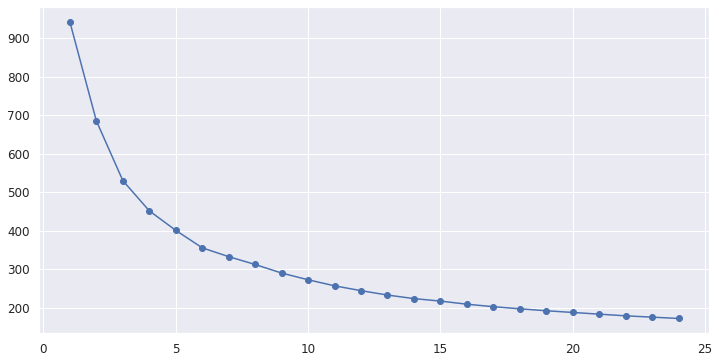

In [46]:
# Plot Cluster Error graph
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

**From above graph we can see elbow will be between 6 and 11**

**Silhouette Coefficient**

In [47]:
# Calculate Silhouette Coefficient for K=6 through K=12
k_range = range(6, 12)
scores = []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(cc_trans_reduced)
    scores.append(metrics.silhouette_score(cc_trans_reduced, km.labels_))

In [48]:
scores

[0.2555276195964952,
 0.23606524021010472,
 0.25086924959481427,
 0.2578048858572796,
 0.22311310615153027,
 0.22400205491529693]

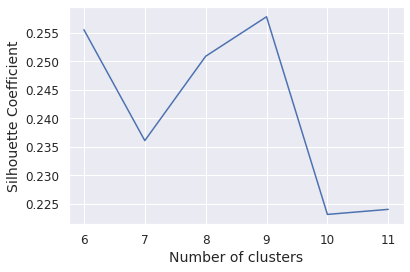

In [49]:
# Plot the Silhouette Coefficient graph
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)

**Number of Clusters can be taken as 7 or 8 or 9**

### **4.2 Clustering**

**Tried number of cluster as 7, 8 and 8. Best clustering was with 8.**

In [90]:
km = KMeans(n_clusters=8, random_state=123)
km.fit(cc_trans_reduced)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=123, tol=0.0001, verbose=0)

In [91]:
# Checking customer counts for each cluster
pd.Series(km.labels_).value_counts()

5    3414
2    2976
1    1939
0    1402
6    1144
4     795
3     773
7     615
dtype: int64

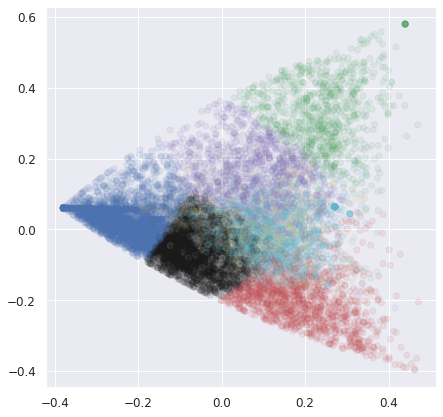

In [92]:
# Plotting Clusters
color_map={0:'r', 1:'c', 2:'b', 3:'y', 4:'g', 5:'k', 6:'m', 7:'w'}
label_color=[color_map[l] for l in km.labels_]
plt.figure(figsize=(7, 7))
plt.scatter(cc_trans_reduced[:, 0], cc_trans_reduced[:, 1], c=label_color, alpha=0.1)

**It is very difficult to draw individual plot for cluster, so we will use pair plot which will provide us all graph in one shot**

In [93]:
df_pair_plot = pd.DataFrame(cc_trans_reduced, columns=['PC_' +str(i) for i in range(6)])
df_pair_plot['Cluster'] = km.labels_ # Add cluster column in the data frame
df_pair_plot.head()

,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,Cluster
0,-0.163734,0.014217,-0.044914,-0.034781,-0.039915,0.003926,2
1,-0.210057,-0.035973,-0.030572,0.035495,-0.021498,0.016939,2
2,-0.214104,-0.042863,-0.054910,0.012256,-0.017606,0.017641,2
3,-0.146036,-0.021835,-0.028058,-0.020559,-0.014653,0.032577,2
4,-0.233971,0.005579,0.004020,-0.014148,-0.033526,0.005902,2


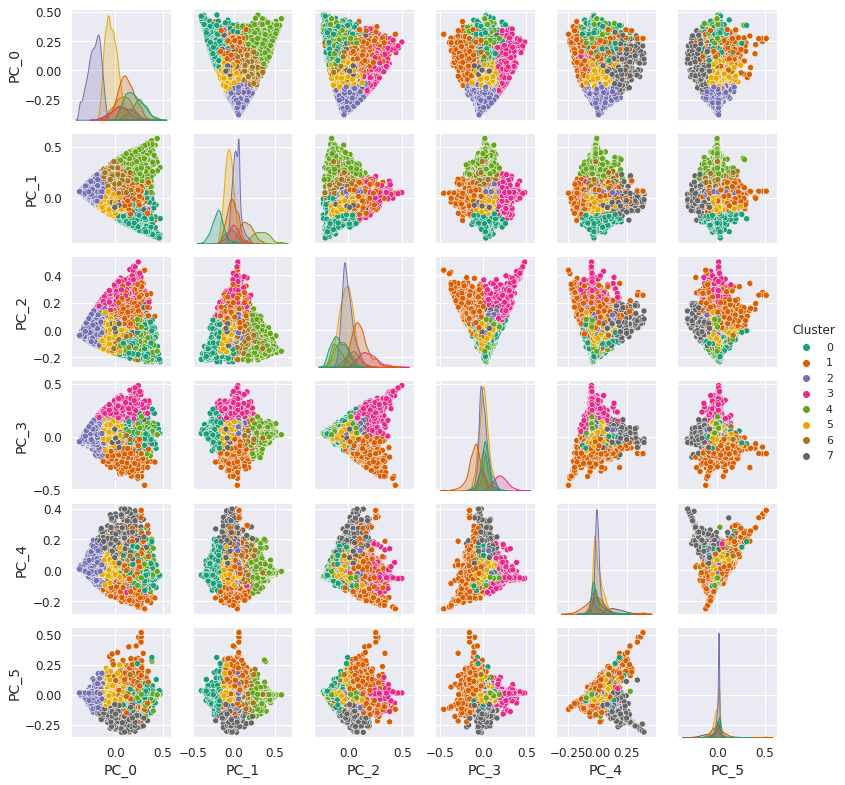

In [95]:
# Pairwise relationship of components on the data
sns.pairplot(df_pair_plot, hue='Cluster', palette='Dark2', diag_kind='kde', height=1.85)

**Now we have done here with priciple component, now we need to come bring our original data frame and we will merge the cluster with them**

**To interprate result we need to use our data frame**

In [97]:
# Conactenating labels found through Kmeans with data 
cluster_df = pd.concat([cc_trans_dummy, pd.Series(km.labels_, name='Cluster')],axis=1)

In [98]:
cluster_df.head()

,Airlines,Business Services,Car Rental,Clothing Stores,Contracted Services,Government Services,Lodging,Professional Services and Membership,Retail Outlet Services,Transportation Services,Utility Services,Cluster
0,0.000000,0.038859,0.00000,0.007883,0.000000,0.0,0.055309,0.0,0.528227,0.057611,0.131353,2
1,0.000000,0.092683,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.559148,0.000000,0.142978,2
2,0.000000,0.060388,0.00000,0.007835,0.000000,0.0,0.000000,0.0,0.567129,0.000000,0.154169,2
3,0.023255,0.052540,0.03562,0.004894,0.003854,0.0,0.034934,0.0,0.504238,0.024775,0.149402,2
4,0.000000,0.073414,0.00000,0.006651,0.000000,0.0,0.048856,0.0,0.572007,0.005977,0.085505,2


In [96]:
# Mean value gives a good indication of the distribution of data. So we are finding mean value for each variable for each cluster
cluster = cluster_df.groupby('Cluster').apply(lambda x: x[cc_trans_dummy.columns.tolist()].mean()).T
cluster

Cluster,0,1,2,3,4,5,6,7
Airlines,0.015962,0.076592,0.005138,0.011116,0.011489,0.016694,0.017650,0.017027
Business Services,0.064720,0.066551,0.067743,0.333282,0.051234,0.073923,0.064126,0.071684
Car Rental,0.016063,0.051961,0.008701,0.015961,0.011852,0.021308,0.019948,0.019077
Clothing Stores,0.012193,0.012632,0.011674,0.012174,0.007473,0.016499,0.012808,0.012820
Contracted Services,0.000818,0.001097,0.000388,0.000654,0.000543,0.000975,0.000834,0.000969
Government Services,0.002703,0.003077,0.004066,0.003664,0.001461,0.004169,0.006713,0.002438
Lodging,0.030439,0.182249,0.017006,0.033006,0.027372,0.041029,0.033809,0.033248
Professional Services and Membership,0.037436,0.039129,0.016847,0.028030,0.021858,0.032858,0.033775,0.231842
Retail Outlet Services,0.227007,0.248528,0.562571,0.264694,0.178656,0.418784,0.321166,0.302930
Transportation Services,0.029247,0.048650,0.026603,0.036668,0.442949,0.028675,0.242965,0.029368


### **Insights - I**

**With the cluster wise mean value of customer's spending on different categories we can conclude as below**
*   **Airlines -** Top 2 spending clusters: 1 and 6
*   **Business Services -** Top 2 spending clusters: 3 and 5
*   **Car Rental -** Top 2 spending clusters: 1 and 5
*   **Clothing Stores -** Top 2 spending clusters: 5 and 7
*   **Contracted Services -** Top 2 spending clusters: 5 and 7
*   **Government Services -** Top 2 spending clusters: 6 and 5
*   **Lodging -** Top 2 spending clusters: 1 and 5
*   **Professional Services and Membership -** Top 2 spending clusters: 1 and 0
*   **Retail Outlet Services -** Top 2 spending clusters: 2 and 5
*   **Transportation Services -** Top 2 spending clusters: 4 and 6
*   **Utility Services -** Top 2 spending clusters: 0 and 5

### **Insights - II**

In [58]:
# Percentage of each cluster in the total customer base
s = cluster_df.groupby('Cluster').apply(lambda x: x['Cluster'].value_counts())
print (s),'\n'

per = pd.Series((s.values.astype('float') / cluster_df.shape[0])*100, name='Percentage')
print ("Cluster"),'\n'
print (pd.concat([pd.Series(s.values, name='Size'), per], axis=1))

Cluster   
0        0    1402
1        1    1939
2        2    2976
3        3     773
4        4     795
5        5    3414
6        6    1144
7        7     615
Name: Cluster, dtype: int64
Cluster
   Size  Percentage
0  1402   10.736713
1  1939   14.849135
2  2976   22.790626
3   773    5.919743
4   795    6.088222
5  3414   26.144892
6  1144    8.760913
7   615    4.709756


* **Big Clusters -** 5 and 2 with ~ 26 and ~ 23 percentage customers respectively. This 2 clusters are covring 50% of the total customers.
* **Medium Clusters -** 1, 0 and 6 with ~ 15, ~ 11 and ~ 9 percentage customers respectively. This 3 clusters are covring 34% of the total customers.
* **Small Cluster -** 4, 3 and 7 with ~ 6, ~6 and ~ 5 percentage customers respectively. This 3 clusters are covring 16% of the total customers.

### **4.3 Cluster / Merchant Category Bar Graph**

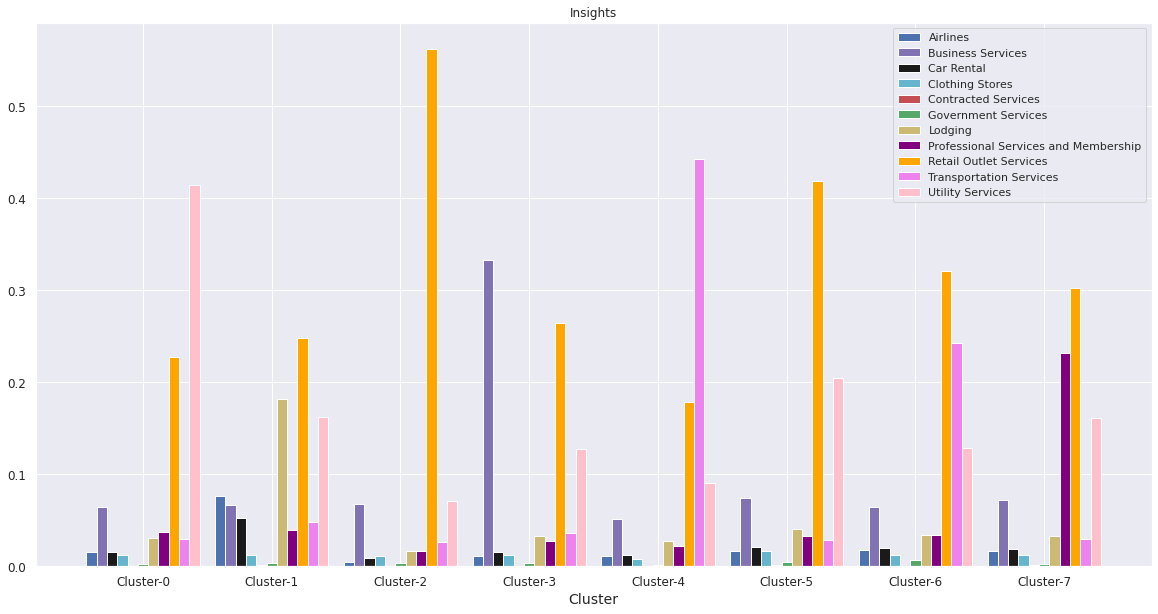

In [59]:
fig, ax = plt.subplots(figsize=(20, 10))
index = np.arange(len(cluster.columns))

airlines = cluster.loc['Airlines', :].values
business_services=(cluster.loc['Business Services', :].values)
car_rental = cluster.loc['Car Rental', :].values
clothing_stores = cluster.loc['Clothing Stores', :].values
contracted_services = cluster.loc['Contracted Services', :].values
government_services = cluster.loc['Government Services', :].values
lodging = cluster.loc['Lodging', :].values
professional_services_membership = cluster.loc['Professional Services and Membership', :].values
retail_outlet_services = cluster.loc['Retail Outlet Services', :].values
transportation_services = cluster.loc['Transportation Services', :].values
utility_services = cluster.loc['Utility Services', :].values

bar_width = 0.08
b1 = plt.bar(index, airlines, color='b', label='Airlines', width=bar_width)
b2 = plt.bar(index+bar_width, business_services, color='m', label='Business Services', width=bar_width)
b3 = plt.bar(index+2*bar_width, car_rental, color='k', label='Car Rental', width=bar_width)
b4 = plt.bar(index+3*bar_width, clothing_stores, color='c', label='Clothing Stores', width=bar_width)
b5 = plt.bar(index+4*bar_width, contracted_services, color='r', label='Contracted Services', width=bar_width)
b6 = plt.bar(index+5*bar_width, government_services, color='g', label='Government Services', width=bar_width)
b7 = plt.bar(index+6*bar_width, lodging, color='y', label='Lodging', width=bar_width)
b8 = plt.bar(index+7*bar_width, professional_services_membership, color='purple', label='Professional Services and Membership', width=bar_width)
b9 = plt.bar(index+8*bar_width, retail_outlet_services, color='orange', label='Retail Outlet Services', width=bar_width)
b10 = plt.bar(index+9*bar_width, transportation_services, color='violet', label='Transportation Services', width=bar_width)
b11 = plt.bar(index+10*bar_width, utility_services, color='pink', label='Utility Services', width=bar_width)

plt.xlabel("Cluster")
plt.title("Insights")
plt.xticks(index + 5*bar_width, ('Cluster-0', 'Cluster-1', 'Cluster-2', 'Cluster-3', 'Cluster-4', 'Cluster-5', 'Cluster-6', 'Cluster-7'))

plt.legend()

### **Insights - III**

**8 Clusters - Understanding each cluster's customers**

1. **Cluster 0**
* Consists of almost 11% of total customers
* Spends more on: Utility Services and Retail Outlet Services - **A generic card user**

2. **Cluster 1**
* Consists of almost 15% of total customers
* Spends more on: Clothing Stores, Airlines and Car Rental - **A traveller**


3. **Cluster 2**
* Consists of almost 23% of total customers
* Spends more on: Retail Outlet Services and Business Services - **A shopper**

4. **Cluster 3**
* Consists of almost 6% of total customers
* Spends more on: Business Services and Retail Outlet Services - **A selective shopper**

5. **Cluster 4**
* Consists of almost 6% of total customers
* Spends more on: Transportation Services and Retail Outlet Services - **A local traveller**

6. **Cluster 5**
* Consists of almost 26% of total customers
* Spends more on: Retail Outlet Services and Utility Services - **A generic user with more on shopping side**

7. **Cluster 6**
* Consists of almost 9% of total customers
* Spends more on: Retail Outlet Services and Transportation Services - **A local businessman**

8. **Cluster 7**
* Consists of almost 5% of total customers
* Spends more on: Retail Outlet Services and Professional Services & Membership - **A gateaway type user**

### **4.4 Adding Clusters to Original Dataset**

In [60]:
# Predicting the labels of the input data
y=km.predict(cc_trans_reduced)

# Adding the labels to a column named label
cc_trans["Label"] = y

#The new dataframe with the clustering done
cc_trans.head(100)

,Customer Id,Airlines,Business Services,Car Rental,Clothing Stores,Contracted Services,Government Services,Lodging,Miscellaneous Stores,Professional Services and Membership,Retail Outlet Services,Transportation Services,Utility Services,Label
0,1000020180,0.00,19087.25,0.00,3812.55,0.0,0.00,27393.80,115864.00,0.00,335237.00,28567.0,67618.60,2
1,1000020181,0.00,39659.20,0.00,0.00,0.0,0.00,0.00,110605.25,0.00,305949.35,0.0,62769.70,2
2,1000020182,0.00,18628.40,0.00,2353.75,0.0,0.00,0.00,133589.40,0.00,228393.20,0.0,49882.70,2
3,1000020183,34771.10,79723.70,53590.60,7250.60,5707.1,0.00,52540.25,417228.70,0.00,969084.55,37072.7,238146.30,2
4,1000020190,0.00,28054.25,0.00,2457.70,0.0,0.00,18439.75,149428.65,0.00,284249.35,2207.8,32875.50,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1001420190,17669.75,34900.25,103993.75,10302.60,0.0,480.55,37402.05,257072.90,78740.20,522594.45,10782.8,1273267.10,0
96,1001420200,0.00,4280.15,0.00,5406.45,0.0,0.00,0.00,42502.95,4529.00,89650.05,0.0,190352.05,0
97,1001520180,0.00,27382.60,19771.50,0.00,0.0,0.00,35190.75,38096.80,1437.80,176585.15,0.0,14763.35,2
98,1001520182,6654.55,16266.95,0.00,0.00,0.0,0.00,0.00,17820.25,7969.50,71558.20,0.0,66665.55,5


# **B. New Customer Cluster Prediction**

## **1. Data Visualization**

### **1.1 Getting Dataset**

In [61]:
# Getting the Credit Card Customer Dataset downloaded from GitHub
!wget -O credit_card_customers.csv 'https://raw.githubusercontent.com/tandonvivek/bits-project/v1-dev/credit_card_customers.csv'

--2021-08-31 09:20:58--  https://raw.githubusercontent.com/tandonvivek/bits-project/v1-dev/credit_card_customers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 510927 (499K) [text/plain]
Saving to: ‘credit_card_customers.csv’

credit_card_custome 100%[===================>] 498.95K  --.-KB/s    in 0.04s   

2021-08-31 09:20:58 (13.8 MB/s) - ‘credit_card_customers.csv’ saved [510927/510927]



### **1.2 Load CC Customer Dataset and do initial raw data analysis**

In [62]:
# Load dataset and check data sample
cc_custs = pd.read_csv("credit_card_customers.csv")
cc_custs.head(100)

,Customer Id,Age,Gender,Occupation,Marital Status
0,1000020180,41,Male,Self-Employed,Married
1,1000020181,46,Male,Employed,Married
2,1000020182,46,Male,Self-Employed,Married
3,1000020183,36,Male,Self-Employed,Married
4,1000020190,35,Male,Self-Employed,Married
...,...,...,...,...,...
95,1001420190,48,Female,Employed,Married
96,1001420200,50,Female,Employed,Married
97,1001520180,39,Male,Self-Employed,Married
98,1001520182,54,Female,Employed,Married


## **2. Data Pre-Processing**

In [63]:
# Find the total number of missing values in the dataframe
print ("\nMissing values :  ", cc_custs.isnull().sum().values.sum())

# Printing total numbers of Unique value in the dataframe. 
print ("\nUnique values :  \n", cc_custs.nunique())


Missing values :   0

Unique values :  
 Customer Id       13058
Age                  30
Gender                2
Occupation            2
Marital Status        2
dtype: int64


In [64]:
# Merge both dataset to get customers personal data added to cluster
cc_merged = pd.merge(left=cc_trans, right=cc_custs, left_on='Customer Id', right_on='Customer Id')

cc_merged

,Customer Id,Airlines,Business Services,Car Rental,Clothing Stores,Contracted Services,Government Services,Lodging,Miscellaneous Stores,Professional Services and Membership,Retail Outlet Services,Transportation Services,Utility Services,Label,Age,Gender,Occupation,Marital Status
0,1000020180,0.0,19087.25,0.00,3812.55,0.0,0.00,27393.80,115864.00,0.00,335237.00,28567.00,67618.60,2,41,Male,Self-Employed,Married
1,1000020181,0.0,39659.20,0.00,0.00,0.0,0.00,0.00,110605.25,0.00,305949.35,0.00,62769.70,2,46,Male,Employed,Married
2,1000020182,0.0,18628.40,0.00,2353.75,0.0,0.00,0.00,133589.40,0.00,228393.20,0.00,49882.70,2,46,Male,Self-Employed,Married
3,1000020183,34771.1,79723.70,53590.60,7250.60,5707.1,0.00,52540.25,417228.70,0.00,969084.55,37072.70,238146.30,2,36,Male,Self-Employed,Married
4,1000020190,0.0,28054.25,0.00,2457.70,0.0,0.00,18439.75,149428.65,0.00,284249.35,2207.80,32875.50,2,35,Male,Self-Employed,Married
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13053,1199820200,37842.0,30226.35,0.00,5616.80,0.0,5618.20,31609.55,33471.20,8742.65,31890.60,31064.25,52788.75,1,31,Female,Self-Employed,Married
13054,1199920181,0.0,790714.40,60002.60,34312.25,11982.6,164.15,172979.80,565726.00,39592.70,572029.50,1375659.95,303310.35,4,26,Male,Employed,Single
13055,1199920191,135730.7,750639.40,81862.55,32845.05,4910.5,126.35,306140.45,543716.25,27724.20,498275.05,1289393.00,318887.80,4,40,Male,Employed,Single
13056,1199920200,0.0,30895.90,0.00,0.00,0.0,0.00,25605.65,15238.65,0.00,28474.25,67084.85,8400.00,4,38,Male,Employed,Single


In [65]:
# Remove merchant catagories as only personal data is required for building prediction model
cc_merged = cc_merged[['Age', 'Gender', 'Occupation', 'Marital Status', 'Label']]

# Change non-numeric data to numeric
cc_merged['Gender'].replace(['Male','Female'],[0, 1],inplace=True)
cc_merged['Occupation'].replace(['Self-Employed','Employed'],[0, 1],inplace=True)
cc_merged['Marital Status'].replace(['Married','Single'],[0, 1],inplace=True)

cc_merged

,Age,Gender,Occupation,Marital Status,Label
0,41,0,0,0,2
1,46,0,1,0,2
2,46,0,0,0,2
3,36,0,0,0,2
4,35,0,0,0,2
...,...,...,...,...,...
13053,31,1,0,0,1
13054,26,0,1,1,4
13055,40,0,1,1,4
13056,38,0,1,1,4


In [89]:
# Find the total number of missing values in the dataframe
print ("\nMissing values :  ", cc_merged.isnull().sum().values.sum())

# Printing total numbers of Unique value in the dataframe. 
print ("\nUnique values :  \n", cc_merged.nunique())


Missing values :   0

Unique values :  
 Age               30
Gender             2
Occupation         2
Marital Status     2
Label              8
dtype: int64


## **3. Model Building**

### **3.1 Training / Testing Data**

Class=2, n=2976 (22.791%)
Class=5, n=3414 (26.145%)
Class=1, n=1939 (14.849%)
Class=3, n=773 (5.920%)
Class=0, n=1402 (10.737%)
Class=4, n=795 (6.088%)
Class=7, n=615 (4.710%)
Class=6, n=1144 (8.761%)


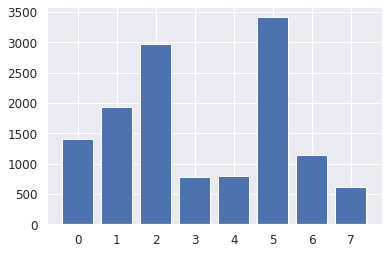

In [67]:
# Split into input and output elements
X = cc_merged.drop(['Label'],axis=1)
y = cc_merged.Label

# Summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

# Plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [68]:
# Dividing Training and Testing data in 80:20
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=True)

### **3.2 Decision Tree Classifier**

In [69]:
# Taining a DescisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
dtree_model = DecisionTreeClassifier(max_depth = 5).fit(X_train, y_train)
DTC_predictions = dtree_model.predict(X_test)

# Model accuracy for X_test  
DTC_accuracy = dtree_model.score(X_test, y_test)

print('DTC Accuracy: ' + str(DTC_accuracy))

DTC Accuracy: 0.7611026033690659


### **3.3 KNN (K-Nearest Neighbours) classifier**

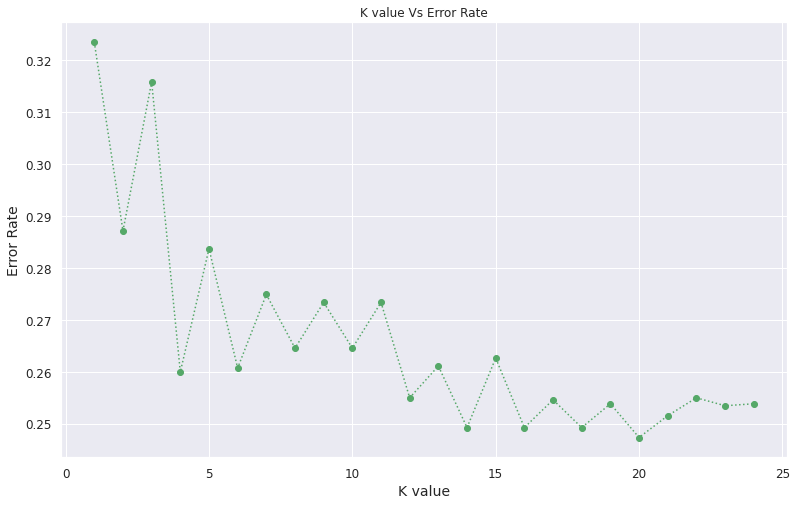

In [70]:
from sklearn.neighbors import KNeighborsClassifier
error_rate=[]
for i in range(1,25):
  knn = KNeighborsClassifier(n_neighbors=i)
  model = knn.fit(X_train,y_train)
  pred_i = knn.predict(X_test)
  error_rate.append(np.mean(pred_i != y_test))
plt.figure(figsize=(13,8))
plt.plot(range(1,25), error_rate, linestyle = 'dotted', marker = 'o',color = 'g')
plt.xlabel('K value')
plt.ylabel('Error Rate')
plt.title('K value Vs Error Rate')
plt.show()

In [73]:
# Training KNN classifier
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors = 20).fit(X_train, y_train)
KNN_predictions = knn_model.predict(X_test)
 
# Model accuracy for X_test
KNN_accuracy = knn.score(X_test, y_test)

print('KNN Accuracy: ' + str(KNN_accuracy))

KNN Accuracy: 0.7461715160796325


### **3.4 Naive Bayes classifier**

In [74]:
# Training Naive Bayes classifier
from sklearn.naive_bayes import GaussianNB
gnb_model = GaussianNB().fit(X_train, y_train)
GNB_predictions = gnb_model.predict(X_test)

# Model accuracy for X_test
GNB_accuracy = gnb_model.score(X_test, y_test)

print('GNB Accuracy: ' + str(GNB_accuracy))

GNB Accuracy: 0.6496937212863706


### **3.5 Random Forest**

In [75]:
# Training random forest classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier

# Define the model
rf_model = RandomForestClassifier().fit(X_train, y_train)

# Evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1)
n_scores = cross_val_score(rf_model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

# Report performance
print('RF Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

RF Accuracy: 0.759 (0.007)


### **3.6 SVM (Support vector machine) classifier**


In [76]:
# Training linear SVM classifier
from sklearn.svm import SVC
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train, y_train)
SVM_predictions = svm_model_linear.predict(X_test)
  
# Model accuracy for X_test  
SVM_accuracy = svm_model_linear.score(X_test, y_test)
  
print('SVM Accuracy: ' + str(SVM_accuracy))

SVM Accuracy: 0.7113323124042878


### **3.7 Accuracy Comparison**

In [80]:
# Accuracy score is the simplest way to evaluate
print('DTC Accuracy: '+str(accuracy_score(DTC_predictions, y_test)))
print('KNN Accuracy: '+str(accuracy_score(KNN_predictions, y_test)))
print('GNB Accuracy: '+str(accuracy_score(GNB_predictions, y_test)))
print('RF Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
print('SVM Accuracy: '+str(accuracy_score(SVM_predictions, y_test)))

DTC Accuracy: 0.7611026033690659
KNN Accuracy: 0.7526799387442573
GNB Accuracy: 0.6496937212863706
RF Accuracy: 0.759 (0.007)
SVM Accuracy: 0.7113323124042878


### **3.8 Confusion matix Comparison**

**But Confusion Matrix and Classification Report give more details about performance**

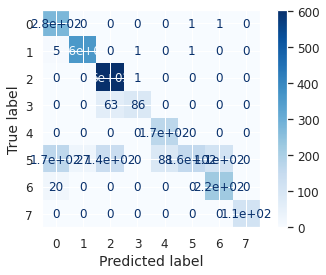

In [81]:
# Decision Tree Confusion Matrix
plot_confusion_matrix(dtree_model,X_test,y_test,cmap=plt.cm.Blues)

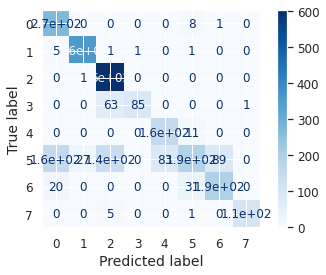

In [82]:
# KNN Confusion Matrix
plot_confusion_matrix(knn_model,X_test,y_test,cmap=plt.cm.Blues)

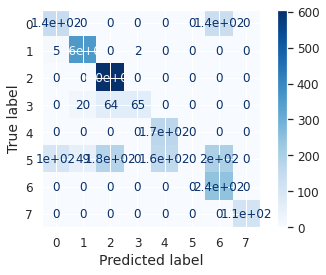

In [83]:
# GNB Confusion Matrix
plot_confusion_matrix(gnb_model,X_test,y_test,cmap=plt.cm.Blues)

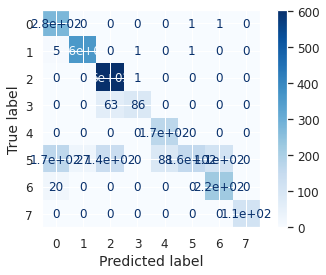

In [84]:
# Random Forest Confusion Matrix
plot_confusion_matrix(rf_model,X_test,y_test,cmap=plt.cm.Blues)

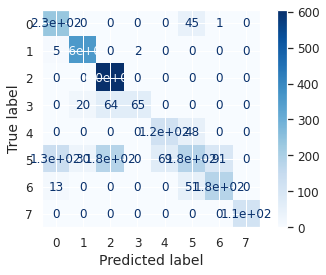

In [85]:
# SVM Confusion Matrix
plot_confusion_matrix(svm_model_linear,X_test,y_test,cmap=plt.cm.Blues)

# **C. Model Testing**

**Selecting model as Decision Tree for predicting**

In [88]:
#@title Model Prediction Evaluation
#@markdown Please select below fields.
#Age	Gender	Occupation	Marital Status
Age = 25  #@param {type: "slider", min: 18, max: 70}
Gender = "Male" #@param ["Male", "Female"] {allow-input: true}
Occupation = "Employed" #@param ["Self-Employed", "Employed"] {allow-input: true}
MaritalStatus = "Married" #@param ["Married", "Single"] {allow-input: true}
Genders={'Male':0,'Female':1}
Occupations={'Self-Employed':0,'Employed':1}
MaritalStatuses={'Married':0,'Single':1}

print([[Age,Genders[Gender],Occupations[Occupation],MaritalStatuses[MaritalStatus]]])
pred_class = dtree_model.predict([[Age,Genders[Gender],Occupations[Occupation],MaritalStatuses[MaritalStatus]]]).tolist()[0]
print('Prediction: '+str(pred_class))

#@markdown ---

[[25, 0, 1, 0]]
Prediction: 5
